# Flatiron School 071519 DS Parttime Online Capstone Project - Citibike Station availability forecasting

## Introduction and Business Problem

New York City residents utilize a number of modes of transportation to get from place to place and need to know they can rely on their preferred mode when they need it. One popular method is the shared bike system operated by Citibike. Citibike has stations in Manhattan, Queens, Brooklyn, and Jersey City. While Citibike does offer information in their application about the real-time availability of their bikes at a given station, there is no application that would allow a biker to know ahead of time whether they can rely on a bike being available at their station of choice (that I know of).

I will aim to solve that problem by constructing a dash application a Citibike user could utilize to plan a trip using a bike from their station of choice.

### Data

The data for this project will come from Citibike System Data. Ideally I would be able to run an API call on their station information, collecting minute by minute availability of bike traffic over the course of the day for a number of weeks. However, at the time I was collecting information for this project, NYC was under a shelter-in-place order to help stop the spread of the novel coronavirus, COVID-19. Given the halt on normal city traffic, I needed a different approach.

I had to utilize rider data from April 2019 and manipulated it to generate a rolling count of bikes being checked in and out of stations. I paired that traffic data with other general information about the stations and ended up with a dataset that had approximate station counts for 741 stations 24/7 for the month. I made daily adjustments to the counts to account for station capacity, and believe this adjustment roughly captured the process of station refilling - where Citibike will shift bikes en masse during off hours to restock empty stations that are popular start points but unpopular destination stations/remove bikes from popular destination stations so more bikes can be docked there.

I also wanted to use weather as a predictive input - intuitively there will likely be more bike traffic when it is nice out and less bike traffic when there is inclement weather.

And while some geographical information was provided in the Citibike datasets, I knew I wanted to pull in more granular information, specifically the NYC neighborhoods where the stations were located.

#### Sourcing
The citibike information comes from two places. 
 - The station information is pulled from their APIs: http://gbfs.citibikenyc.com/gbfs/gbfs.json. 
 - The historical data I use is coming from their Citi Bike Daily Ridership and Membership Data here: https://www.citibikenyc.com/system-data
 
I use historical weather data from New York that is sourced from the World Weather Online Developer Portal API here: https://www.worldweatheronline.com/developer/api/docs/historical-weather-api.aspx

I use MapBox for geospatial data to identify NYC neighborhoods

### Process

After gathering and cleaning the data, I fit and tuned various Machine Learning classification models to predict, given a number of inputs, a classification problem of whether the number of bikes at the station at a given time will be low, medium, or high.

The output is code for a web based application deployed in dash.

## Libraries

In [2]:
#
import pandas as pd 
import requests #For API calls
import datetime #For feature formatting
import matplotlib.pyplot as plt #Viz
%matplotlib inline
import seaborn as sns #Viz
import time #for the API call I don't use
import os #For the weather call
import json #file formatting
from pandas.io.json import json_normalize #file formatting
from sklearn.utils import resample

#!pip install wwo-hist
from wwo_hist import retrieve_hist_data #historical weather 
from mapbox import Geocoder
MAPBOX_ACCESS_TOKEN="pk.eyJ1IjoienphenVldGEiLCJhIjoiY2s5N2locWV0MTcxYzNlcGdrYzdkcjh2aCJ9.0JA5P2qFBnre_I0dZ3wcsw"

import folium
from folium.plugins import MarkerCluster

import warnings
warnings.filterwarnings("ignore")

## Data & Data cleaning

If I were to do this project again at a different time (not during a city lockdown for a global pandemic), I would use this code to source the data. The below code will query the station status API CitiBike has. This API will list the number of bikes in a station at the time of the call. What this method would capture, which the data I use does not capture, is the refilling of stations conducted by CitiBike crews - there are some stations that will more often act as end stations or start stations, meaning more bikes will be removed from the station than returned over the course of the day, therefore leaving the station empty with little likelihood of refilling or the stations are more consistently full, limiting the use of the station as a dock to return a bike. To remedy this, crews will move excess bikes from the full stations to the emptier stations to rebalance availability.

The below code tracks a start time, generates a blank count and an empty dataframe, and then pulls a request every X seconds from the listed API, appending the DF and adding a count. The current code is written to repeat every 15 minutes (900 seconds) for 10 hours (count <40). I would likely pull this every 2 minutes for 12 hour periods for a month to obtain a similar data set.

In [ ]:
# starttime=time.time()
# count=0
# j = pd.DataFrame(columns=['station_id', 'num_bikes_available', 
#                           'num_ebikes_available', 'num_bikes_disabled', 
#                           'num_docks_available', 'num_docks_disabled', 
#                           'is_installed', 'is_renting', 'is_returning', 
#                           'last_reported', 'eightd_has_available_keys'])
# while count<40:
#     resp = requests.get('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')
#     response = resp.json()
#     for i in response['data']['stations']:
#         currentDT = datetime.datetime.now()
#         i['time_pulled'] = currentDT.strftime("%Y-%m-%d %H:%M:%S")
#         j = j.append(i, ignore_index=True)
#     time.sleep(900.0 - ((time.time() - starttime) % 900.0))
#     count+=1
#
# j.head(10)

Because there has been limited bike traffic in NYC over the last few months with the public health crisis, I have reverted to using historical data. The below code pulls in basic information about the regions associated with the bike stations.

In [3]:
#
#This is an API call to get the region IDs that are associated with each station
resp = requests.get('https://gbfs.citibikenyc.com/gbfs/en/system_regions.json')
response = resp.json()  
ids = json_normalize(response['data']['regions'])
ids

,name,region_id
0,JC District,70
1,NYC District,71
2,8D,158
3,Bronx,185
4,IC HQ,189
5,testzone,190


In [4]:
#
ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
name         6 non-null object
region_id    6 non-null object
dtypes: object(2)
memory usage: 224.0+ bytes


The below code pulls in the data file, a list of rides from April 2019. The link to the location of the original data file can be found at the top of the page in the intro.

In [5]:
#
#This is a csv that contains 1.76 million rides for April 1, 2019 - April 30, 2019
rides = pd.read_csv('201904-citibike-tripdata.csv')
rides.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,88,2019-04-01 00:00:14.7410,2019-04-01 00:01:42.8900,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,36515,Subscriber,1982,1
1,443,2019-04-01 00:00:20.8270,2019-04-01 00:07:44.2920,254,W 11 St & 6 Ave,40.735324,-73.998004,540,Lexington Ave & E 29 St,40.743116,-73.982154,17406,Subscriber,1983,1
2,662,2019-04-01 00:00:30.9960,2019-04-01 00:11:33.2610,3244,University Pl & E 8 St,40.731437,-73.994903,3244,University Pl & E 8 St,40.731437,-73.994903,20775,Subscriber,1988,1


In [6]:
#
#I don't need trip duration for this analysis. Nor do I need information about the
#individual bikes or the customer.
rides = rides.drop(['tripduration', 'bikeid', 'usertype', 'birth year', 
                    'gender', 'start station name', 'end station name'], axis=1)

#Check for NAs
rides.isna().sum()

starttime                  0
stoptime                   0
start station id           0
start station latitude     0
start station longitude    0
end station id             0
end station latitude       0
end station longitude      0
dtype: int64

In [7]:
#
# This is an API call to get the infomrmation about each station. Use this for 
# Station ID, Region ID, capacity, locale
resp = requests.get('https://gbfs.citibikenyc.com/gbfs/en/station_information.json')
response = resp.json()  
#This normalizes the semi-formatted json into a flat table
stat_info = json_normalize(response['data']['stations'])
stat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
region_id                         971 non-null object
electric_bike_surcharge_waiver    973 non-null bool
short_name                        973 non-null object
station_type                      973 non-null object
rental_url                        973 non-null object
lon                               973 non-null float64
capacity                          973 non-null int64
external_id                       973 non-null object
name                              973 non-null object
eightd_has_key_dispenser          973 non-null bool
lat                               973 non-null float64
rental_methods                    973 non-null object
eightd_station_services           973 non-null object
has_kiosk                         973 non-null bool
station_id                        973 non-null object
dtypes: bool(3), float64(2), int64(1), object(9)
memory usage: 94.2+ KB


In [8]:
#
#Join the IDs df in to distinguish station regions
stat_info = stat_info.merge(ids, on='region_id')

#We only need a few pieces of information from this table
stat_info = stat_info[['capacity', 'station_id', 'name_y', 'lat', 'lon']]

#Convert station_id into int type
stat_info['station_id'] = stat_info['station_id'].astype('int64')

I utlized Mapbox, an open source mapping platform to reverse geocode the NYC neighborhood using station latitude and longitude.

In [9]:
#
geocoder = Geocoder(access_token = MAPBOX_ACCESS_TOKEN)

#Generate a dictionary that has the station_id as key and NYC neighborhood as value
nbdict = {}
for i in stat_info.index:
    lon = stat_info.lon[i]
    lat = stat_info.lat[i]
    responsegeo = geocoder.reverse(lon=lon, lat=lat)
    nbdict[stat_info.station_id[i]] = responsegeo.geojson()['features'][0]['context'][0]['text']
    
stat_info['neighborhood'] = [nbdict[i] for i in stat_info.station_id]
stat_info['stat_size'] = ['Small' if i <= 23 else 'Medium' if i <= 30 else 
                          'Large' if i <=45 else 'Extra Large' for i in stat_info['capacity']]

stat_info.head(3)

,capacity,station_id,name_y,lat,lon,neighborhood,stat_size
0,55,72,NYC District,40.767272,-73.993929,Columbus Circle,Extra Large
1,33,79,NYC District,40.719116,-74.006667,Tribeca,Large
2,27,82,NYC District,40.711174,-74.000165,Lower East Side,Medium


In [10]:
#
stat_info.stat_size.value_counts()

Small          310
Large          286
Medium         251
Extra Large    124
Name: stat_size, dtype: int64

In [11]:
#
#This pulls the unique station ids from rides and joins the unique values
start = [i for i in rides['end station id'].unique()]
end = [i for i in rides['start station id'].unique()]
        
rides_stations = list(set().union(start, end))

#These are the unique station ids we have station info for
one = [i for i in stat_info.station_id]

#This generates a list of station ids that are in stat_info and not in rides 
# - stations we have information for but no rides associated with. These are 
#likely stations that have been added after April 2019, since the station 
#info call is current (May 2020).
list_diff = []
for i in one:
    if i not in rides_stations:
        list_diff.append(i)
        
#This drops the rows in stat_info that are not in rides
stat_info = stat_info[~stat_info['station_id'].isin(list_diff)]

#These are the unique station ids we have station info for
one = [i for i in stat_info.station_id]

#This generates a list of station ids that are in rides and not in stat_info
# - stations with rides associated with them, but we don't have information about
list_diff = []
for i in rides_stations:
    if i not in one:
        list_diff.append(i)
        
#This drops the rows in stat_info that are not in rides
rides = rides[~rides['end station id'].isin(list_diff)]
rides = rides[~rides['start station id'].isin(list_diff)]

#This generates a dictionary of station ids and their capacity
stat_info_dict = {}
for i in stat_info.index:
    stat_info_dict[stat_info.loc[i]['station_id']] = stat_info.loc[i]['capacity']

For the next part, I want to generate a DataFrame that will track bikes leaving and being returned to each station over time. To do this, I want to take my rides dataframe and separate the trip start and trip end information. I don't need to consider the start and end of a trip as the same trip - I am just worried about bikes in the station, so whether someone checked a bike out and returned it to the same station after one minute, or whether the bike was checked out and then returned to a station across town days later does not matter, as long as I know where and when an event (bike checked in or out) occurred.

In [ ]:
#
bikes_out = rides[['starttime', 'start station id', 'start station latitude', 
                   'start station longitude']]
bikes_in = rides[['stoptime', 'end station id', 'end station latitude', 
                  'end station longitude']]

#Converts the trip start time to datetime format
bikes_out['starttime'] = pd.to_datetime(bikes_out.starttime)
bikes_in['stoptime'] = pd.to_datetime(bikes_in.stoptime)

#Adds a column to denote the day of the week, M-Sun (0-6)
bikes_out['dow'] = list(map(lambda x: x.weekday(), bikes_out.starttime))
bikes_in['dow'] = list(map(lambda x: x.weekday(), bikes_in.stoptime))

#Codes a 0 if the dow is M-F (0-4), 1 if dow is Sat or Sun (5-6)
bikes_out['weekend?'] = [0 if i < 5 else 1 for i in bikes_out.dow]
bikes_in['weekend?'] = [0 if i < 5 else 1 for i in bikes_in.dow]

#Add in a count feature to show movement of the bikes. Bikes out gets a 
#negative count because a bike is leaving a station at the start of a trip,
#bikes in gets a positive count becuase a bike is returned at the end of 
#a trip
bikes_out['count'] = -1
bikes_in['count'] = 1

Another feature I want to include is weather - it makes intuitive sense that weather would likely be a strong factor in how bikes are being used. I am pulling from the world weather online developer portal and pulling historic data from New York for the month of April 2019.

In [ ]:
#
#This cell pulls hourly data from the world weather online developer portal 
#for the month of April 2019

# !pip install wwo-hist
os.chdir(r"C:\Users\zazue\Data Science\Capstone")

frequency=1
start_date = '01-APR-2019'
end_date = '30-APR-2019'
api_key = '3d680cf1ceb24ee2962203644201704'
location_list = ['new+york']

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)

#This exports the data to a csv file in the directory.

In [ ]:
#
#Read in the csv file
weather = pd.read_csv('new+york.csv')

#The file had duplicated the rows, so I drop the duplicates
weather = weather.drop_duplicates(keep='first')

#Convert the date_time to datetime
weather['date_time'] = pd.to_datetime(weather.date_time)

#Extract just the necessary columns
weather = weather[['date_time', 'tempC']]

#Calculate the temperature to Fahrenheit
weather['tempF'] = list(map(lambda x: x * (9/5) + 32, weather['tempC']))

#Make a unique day_hour component to use as a unique identifier for information joins
weather['day_hour'] = list(map(lambda x: '0' + str(x.day) + '0' + str(x.hour), 
                               weather.date_time))
weather.head(3)

In [ ]:
#
#Create the same day_hour column to bring in the weather information.
bikes_out['day_hour'] = list(map(lambda x: '0' + str(x.day) + '0' + 
                                 str(x.hour), bikes_out.starttime))

#Join the weather data on the bikes_out df
bikes_out = pd.merge(bikes_out, weather[['day_hour', 'tempF']], on='day_hour', 
                     how='left')
bikes_out.head()

In [ ]:
#
#This is selecting the time, station id, and a counter for each station (+1 
#for a bike being returned from bikes_in, -1 for a bike being checked out from 
#bikes_out)
bsout = bikes_out[['count']]
bsout['time'] = bikes_out['starttime']
bsout['stat_id'] = bikes_out['start station id']
bsin = bikes_in[['count']]
bsin['time'] = bikes_in['stoptime']
bsin['stat_id'] = bikes_in['end station id']

counts = [bsout, bsin]

#I then concatenate the two frames
ts = pd.concat(counts, ignore_index=True).sort_values(by=['time'])
ts = ts.set_index('time')

Here, I loop through each station in the unique stations (744). For each station, I loop through each day in the month. For each day, I generate a dataframe of ordered rides. For each ride a counter is applied to indicate whether a bike entered or left the station. The start count of the station is started at the max capacity for the station.

What is happening here is that I am saying a station can have a count of bikes that is higher than what it can actually hold. I correct for that below.

In [ ]:
#
april_rides = pd.DataFrame(columns=['count', 'stat_id', 'ct'])
for i in ts['stat_id'].unique():
    for j in range(1,31):
        x = ts[ts.index.day == j]
        starting_cap = stat_info_dict[i]
        bike_count = starting_cap
        y = x[x['stat_id'] == i]
        z = []
        for k in y['count']:
            bike_count += k
            z.append(bike_count)
        y['ct'] = z
        stations = [april_rides, y]
        april_rides = pd.concat(stations, ignore_index=False)
    
april_rides.head(5)

In [ ]:
#
#Here I put the time stamp back on index. I use the index to map
#the unique day_hour identifier for weather and then merge weather
#by day and hour into the frame.
april_rides = april_rides.reset_index()
april_rides['day_hour'] = list(map(lambda x: '0' + str(x.day) + '0' + 
                                   str(x.hour), april_rides['index']))
april_rides = pd.merge(april_rides, weather[['day_hour', 'tempF']], 
                       on='day_hour', how='left')
print(len(april_rides))
april_rides.head()

In [ ]:
#
#Then I need to bring in the station id and neighborhood
april_rides = pd.merge(april_rides, stat_info[['station_id', 'neighborhood']], 
                       left_on='stat_id', right_on='station_id', how='left')

In [ ]:
#
#Quick check to ensure all rows were maintained
len(april_rides)

In [ ]:
#
#744 stations were used in the month of April 2019
len(april_rides.stat_id.unique())

In [ ]:
#
april_rides.head()

Now, I will iterate through the list again. This time, for each station, I determine what the maximum number of bikes in the station was for the day. I then subtract the station capacity from the max daily bike count and use that number as the starting number of bikes for the day at midnight. This assumes that stations are mostly empty in the night and fill up over the course of the day.

I then mark stations that eventually have a negative count of bikes over the course of the day. Again, this would happen because I cannot capture the manipulation of bike count with this data source.

In [ ]:
#
#Generate a blank df
april_rides2 = pd.DataFrame(columns=['count', 'stat_id', 'ct', 'ct_revised'])

#Set the index as the time stamp
april_rides = april_rides.set_index('index')

#For every unique station id
for i in april_rides['stat_id'].unique():
    
    #subset the df by station id
    a = april_rides[april_rides['stat_id']==i]
    
    #For every day in April 1-30
    for j in range(1,31):
        
        #Further subset the data into the rides for the day
        x = a[a.index.day == j]
        
        #Subtract station capacity from max daily count
        bike_count = x['ct'].max()-stat_info_dict[i]
        
        #Generate a list of new station count values and set a revised count column
        y = []
        for k in x['count']:
            bike_count += k
            y.append(bike_count)
        x['ct_revised'] = y
        
        #Generate a list that is the station availability - three categories
        #at 0-20/20-60/60+% capacity
        z = []
        for m in x['ct_revised']:
            cat = m/stat_info_dict[i]
            z.append('Low' if cat < .2 else 'Moderate' if cat < .6 else 'High')
        x['status'] = z
        
        #Note if a station's capacity ever drops below 0
        x['ever_neg'] = 1 if x.ct_revised.min() < 0 else 0
        
        #Concat the new daily counts into the frame
        new_counts = [april_rides2, x]
        april_rides2 = pd.concat(new_counts, ignore_index=False)

In [ ]:
#
#Save the above to a csv - THIS IS THE MASTER CSV FOR MODELING
april_rides2.to_csv('april_rides2.txt')

The final step of the cleaning process will be to drop any station-day pairs where the count drops below 0. A station would not be able to have fewer than 0 bikes, so clearly the number of bikes in the station were manipulated by Citibike crews.

In [12]:
#
#Here just read the above data back in
april_rides = pd.read_csv('april_rides2.txt', delimiter=',')
print(len(april_rides))

3145962


In [13]:
#
#Here drop the timestamp column, pull out the day info, and generate a list
#of each day at each station and drop the duplicates
april_rides['Unnamed: 0'] = pd.to_datetime(april_rides['Unnamed: 0'])
april_rides['day'] = [str(i.day) for i in april_rides['Unnamed: 0']]
april_rides['day_station'] = april_rides['day'] + ' - ' + [str(i) for i in april_rides['stat_id']]
ar = april_rides.drop_duplicates(['day_station'], keep='first')
len(ar)

21731

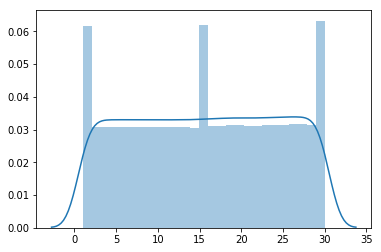

In [14]:
#
#Checking the distribution of days represented in the data to ensure equal 
#distribution of days
y = [int(i) for i in ar['day']]
sns.distplot(y)

In [15]:
#
ar['day'].value_counts(normalize=True)

30    0.034007
27    0.033915
26    0.033915
29    0.033915
28    0.033869
25    0.033823
24    0.033685
20    0.033639
23    0.033639
19    0.033593
22    0.033547
18    0.033455
21    0.033408
17    0.033362
16    0.033270
15    0.033178
1     0.033040
13    0.033040
6     0.033040
2     0.033040
8     0.032994
3     0.032994
5     0.032994
4     0.032994
12    0.032994
7     0.032948
10    0.032948
11    0.032948
9     0.032948
14    0.032856
Name: day, dtype: float64

The distribution of days of the month appears to be fairly uniform.

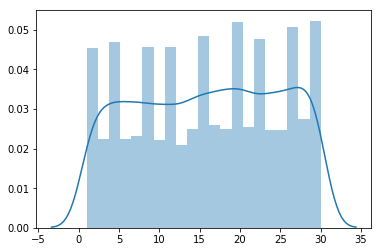

In [16]:
#
#This is the distribution of days if we pull out the whole station day if
#it drops below 0. We clearly see some shifts in how that would be distributed
notdrop = ar[ar['ever_neg'] == 0]

y = [int(i) for i in notdrop['day']]
sns.distplot(y)

In [17]:
#
notdrop['day'].value_counts(normalize=True)

28    0.037986
20    0.036601
30    0.036502
17    0.035810
29    0.035711
27    0.035513
23    0.035315
21    0.035216
19    0.035117
26    0.034623
14    0.034425
18    0.034326
15    0.034128
24    0.034029
25    0.034029
1     0.033040
5     0.032842
16    0.032743
8     0.032545
11    0.032248
4     0.032051
7     0.031853
6     0.031061
3     0.031061
12    0.030963
9     0.030666
22    0.030468
10    0.030468
2     0.029677
13    0.028984
Name: day, dtype: float64

While there is some loss of uniformity, there are no glaring shifts to the data - no days seem to go without a loss of rows

In [18]:
#
nba = {}
nbb = {}
for i in ar.neighborhood.unique():
    a = ar[ar['neighborhood'] == i]
    nba[i] = len(a)
    
for i in notdrop.neighborhood.unique():
    a = notdrop[notdrop['neighborhood'] == i]
    nbb[i] = len(a)

In [19]:
#
nbc = {}
for i in nba.keys():
    nbc[i] = [nbb[i]/nba[i]]
    
nbc

{'Central Park': [0.20666666666666667],
 'Greenwich Village': [0.6516587677725119],
 'Flatiron District': [0.8729166666666667],
 'Gramercy': [0.46944444444444444],
 'Upper East Side': [0.5267111853088481],
 'Garment District': [0.6575757575757576],
 'Harlem': [0.36325678496868474],
 'Bedford Stuyvesant': [0.3376494023904382],
 'Chelsea': [0.5980392156862745],
 'East Village': [0.09473684210526316],
 'Brooklyn Heights': [0.35714285714285715],
 'Stuyvesant Town': [0.08333333333333333],
 'NoHo': [0.9444444444444444],
 'Astoria': [0.5054629097182288],
 'Greenpoint': [0.28431372549019607],
 'SoHo': [0.8],
 'Gowanus': [0.3745928338762215],
 'Financial District': [0.7949886104783599],
 'Downtown': [0.7814814814814814],
 'Williamsburg': [0.43293954134815843],
 'Tribeca': [0.7977777777777778],
 'Hunters Point': [0.6377952755905512],
 'Midtown': [0.8671875],
 'Clinton Hill': [0.18666666666666668],
 'Morningside Heights': [0.6909090909090909],
 'Murray Hill': [0.7888888888888889],
 'Cobble Hill':

In [20]:
#
#Here is an initial distribution of status counts
april_rides.status.value_counts()

Low         1404260
High        1054507
Moderate     687195
Name: status, dtype: int64

In [21]:
#
#Here I compare whether the station count ever exceeds station capacity
#This should have been caught in the initial coding, but wasn't.
april_rides = april_rides[april_rides['ct_revised'] >= 0]
april_rides = pd.merge(april_rides, stat_info[['station_id', 'capacity']], 
                       left_on='stat_id', right_on='station_id', how='left')
april_rides['check'] = april_rides['capacity'] - april_rides['ct_revised']
april_rides = april_rides[april_rides['check'] >= 0]
april_rides.status.value_counts()

Moderate    681854
Low         472417
High        428537
Name: status, dtype: int64

In [22]:
#
#I wanted to work with a smaller data set and downsample to 1.2 million rows
df_high = april_rides[april_rides.status == 'High']
df_mod = april_rides[april_rides.status == 'Moderate']
df_low = april_rides[april_rides.status == 'Low']

df_high_downsampled = resample(df_high, replace=False, 
                               n_samples=400000, random_state=123)

df_mod_downsampled = resample(df_mod, replace=False, 
                              n_samples=400000, random_state=123)

df_low_downsampled = resample(df_low, replace=False, 
                              n_samples=400000, random_state=123)

april_rides_downsampled = pd.concat([df_high_downsampled, df_mod_downsampled, df_low_downsampled])

april_rides_downsampled.status.value_counts()

Low         400000
Moderate    400000
High        400000
Name: status, dtype: int64

In [23]:
#
#Here I pull out the columns I need
april_rides_downsampled = april_rides_downsampled[['status', 'ct_revised', 'day_hour', 
                                                   'neighborhood', 'stat_id', 'tempF', 'Unnamed: 0']]

#I set the datetime to datetime and codes a 0 if the dow is M-F (0-4)
april_rides_downsampled['Unnamed: 0'] = pd.to_datetime(april_rides_downsampled['Unnamed: 0'])
april_rides_downsampled['dow'] = list(map(lambda x: x.weekday(), april_rides_downsampled['Unnamed: 0']))

#Codes a 1 if dow is Sat or Sun (5-6)
april_rides_downsampled['weekend?'] = [0 if i < 5 else 1 for i in april_rides_downsampled.dow]

#Pulls out the hour
april_rides_downsampled['hour'] = [i.hour for i in april_rides_downsampled['Unnamed: 0']]

#Drop the datetime
april_rides_downsampled = april_rides_downsampled.drop('Unnamed: 0', axis=1)

#Merge in the station size
april_rides_downsampled = pd.merge(april_rides_downsampled, 
                                   stat_info[['station_id', 'stat_size']], 
                                   left_on='stat_id', right_on='station_id', how='left')

#Need to roll up the counts by station averaged by day of week and hour
nums = april_rides_downsampled.groupby(['stat_id', 'dow', 'hour']).mean()

nums = nums.reset_index()

#Need to make a matching key to bring in the average hourly station count
nums['stat_id'] = [str(i) for i in nums['stat_id']]
nums['dow'] = [str(i) for i in nums['dow']]
nums['hour'] = [str(i) for i in nums['hour']]

nums['matching_key'] = nums['stat_id'] + ' - ' + nums['dow'] + ' - ' + nums['hour']

In [24]:
#
#Generate a similar matching key
april_rides_downsampled['stat_id'] = [str(i) for i in april_rides_downsampled['stat_id']]
april_rides_downsampled['matching_key'] = april_rides_downsampled['stat_id'] + ' - ' + [str(i) for i in april_rides_downsampled['dow']] + ' - ' + [str(i) for i in april_rides_downsampled['hour']]

#Merge in the real station count averaged by day of week and hour by station
april_rides_downsampled = pd.merge(april_rides_downsampled, 
                                   nums[['matching_key', 'ct_revised']], 
                                   on='matching_key', how='left')

a = ['neighborhood', 'dow', 'weekend?', 'hour', 'stat_size']

#Generating a dictionary where the key is the column name and the value
#is a DF of dummy variable columns, dropping the first instance to avoid multicollinearity
b = {}
for i in a:
    b[i] = pd.get_dummies(april_rides_downsampled[i], prefix=i, drop_first=True)
    
april_rides_downsampled = april_rides_downsampled.drop(['day_hour', 'neighborhood', 
                                                        'dow', 'station_id', 
                                                        'matching_key', 'weekend?', 
                                                        'hour', 'stat_size'], axis=1)

for i in b.keys():
    april_rides_downsampled = pd.concat([april_rides_downsampled, b[i]], axis=1)

#Discard the set revised count
april_rides_downsampled['ct_revised'] = [round(i) for i in april_rides_downsampled['ct_revised_y']]
april_rides_downsampled = april_rides_downsampled.drop(['ct_revised_x', 'ct_revised_y', 'stat_id'], axis=1)

april_rides_downsampled.head()

,status,tempF,neighborhood_Battery Park,neighborhood_Bedford Stuyvesant,neighborhood_Boerum Hill,neighborhood_Brooklyn Heights,neighborhood_Bushwick,neighborhood_Carnegie Hill,neighborhood_Carroll Gardens,neighborhood_Central Park,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,stat_size_Large,stat_size_Medium,stat_size_Small,ct_revised
0,High,62.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
1,High,62.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,16
2,High,69.8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,22
3,High,62.6,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,30
4,High,53.6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,30


In [25]:
#
#THIS IS THE MASTER CSV FOR MODELING
april_rides_downsampled.to_csv('april_rides_downsampled.txt')

### Data for App

I need to generate a few dictionaries that can be referenced in the dash application.

In [26]:
#
#Pull the initial rides data back in
rides2 = pd.read_csv('201904-citibike-tripdata.csv')
rides2 = rides2[['start station id', 'start station name', 'end station id', 
                 'end station name']]
rides2['stat_id'] = rides2['start station id']

In [27]:
#
#This dict pulls together a list of unique station ids and assigns their
#name per the rides data
stat_name_dict = {}
b = [i for i in stat_info['station_id']]
for i in rides2['start station id'].unique():
    if i in b:
        c = rides2[rides2['start station id'] == i]
        stat_name_dict[i] = [j for j in c['start station name']][0]
        
for i in rides2['end station id'].unique():
    if i not in stat_name_dict.keys():
        c = rides2[rides2['end station id'] == i]
        stat_name_dict[i] = [j for j in c['end station name']][0]

#This dict sets a neighborhood name with a tuple of station name and 
#station size ('Small', 'Medium', 'Large', 'Extra Large')
neighb_name_dict = {}
for i in stat_name_dict.keys():
    if i in stat_info['station_id'].unique():
        c = stat_info[stat_info['station_id'] == i]
        neighb_name_dict[i] = ([j for j in c['neighborhood']][0], 
                               [k for k in c['stat_size']][0])

In [28]:
#
nums['stat_name_size'] = tuple(zip([stat_name_dict[int(i)] for i in nums['stat_id']], 
                              [neighb_name_dict[int(i)][1] for i in nums['stat_id']]))
nums['stat_neighb'] = [neighb_name_dict[int(i)][0] for i in nums['stat_id']]
nums['stat_name'] = [stat_name_dict[int(i)] for i in nums['stat_id']]

nums['ct_revised'] = [round(i) for i in nums['ct_revised']]
nums['d_h_key'] = nums['dow'] + ' - ' + nums['hour']

#A note on how to referece the MultiIndex of nums
#nums.index.get_level_values('stat_id').unique()

In [29]:
#
#This generates a dict of the neighborhoods with their stations
dict_of_stations = {}

for i in nums['stat_neighb'].unique():    
    x = nums[nums['stat_neighb'] == i]
    nblist = []
    for j in x['stat_name'].unique():
        nblist.append(j)
        
    dict_of_stations[i] = nblist

In [30]:
dict_of_stations

{'Columbus Circle': ['W 52 St & 11 Ave',
  'W 54 St & 9 Ave',
  'W 53 St & 10 Ave',
  'W 56 St & 10 Ave',
  '11 Ave & W 59 St',
  'W 50 St & 9 Ave'],
 'Tribeca': ['Franklin St & W Broadway',
  'Hudson St & Reade St',
  'Laight St & Hudson St',
  'Harrison St & Hudson St',
  'Lispenard St & Broadway',
  'Duane St & Greenwich St',
  'Murray St & West St',
  'Leonard St & Church St',
  'Watts St & Greenwich St',
  'Reade St & Broadway',
  '6 Ave & Canal St',
  'Barclay St & Church St',
  'Murray St & Greenwich St',
  'North Moore St & Greenwich St',
  'Park Pl & Church St'],
 'Lower East Side': ['St James Pl & Pearl St',
  'Stanton St & Chrystie St',
  'Madison St & Montgomery St',
  'Pike St & E Broadway',
  'Canal St & Rutgers St',
  'St James Pl & Oliver St',
  'Norfolk St & Broome St',
  'Allen St & Stanton St',
  'Pike St & Monroe St',
  'Cherry St',
  'Madison St & Clinton St',
  'Stanton St & Mangin St',
  'Columbia St & Rivington St',
  'Rivington St & Ridge St',
  'Clinton St & G

In [31]:
#
#This generates a dict of neighborhoods with their station names and sizes
dict_of_stat_size = {}

for i in nums['stat_neighb'].unique():    
    x = nums[nums['stat_neighb'] == i]
    nbsizedict = {}
    for j in x['stat_name_size'].unique():
        nbsizedict[j[0]] = j[1]
        
    dict_of_stations[i] = nbsizedict

In [32]:
dict_of_stations

{'Columbus Circle': {'W 52 St & 11 Ave': 'Extra Large',
  'W 54 St & 9 Ave': 'Medium',
  'W 53 St & 10 Ave': 'Medium',
  'W 56 St & 10 Ave': 'Medium',
  '11 Ave & W 59 St': 'Medium',
  'W 50 St & 9 Ave': 'Medium'},
 'Tribeca': {'Franklin St & W Broadway': 'Large',
  'Hudson St & Reade St': 'Large',
  'Laight St & Hudson St': 'Small',
  'Harrison St & Hudson St': 'Medium',
  'Lispenard St & Broadway': 'Large',
  'Duane St & Greenwich St': 'Medium',
  'Murray St & West St': 'Large',
  'Leonard St & Church St': 'Large',
  'Watts St & Greenwich St': 'Small',
  'Reade St & Broadway': 'Large',
  '6 Ave & Canal St': 'Extra Large',
  'Barclay St & Church St': 'Medium',
  'Murray St & Greenwich St': 'Large',
  'North Moore St & Greenwich St': 'Medium',
  'Park Pl & Church St': 'Large'},
 'Lower East Side': {'St James Pl & Pearl St': 'Medium',
  'Stanton St & Chrystie St': 'Large',
  'Madison St & Montgomery St': 'Small',
  'Pike St & E Broadway': 'Medium',
  'Canal St & Rutgers St': 'Medium',
 

In [33]:
#
#This generates a dict of stations by name with their average station count
#per hour by day of the week 
list_of_dicts = {}

for i in nums['stat_name'].unique():    
    x = nums[nums['stat_name'] == i]
    hddict = {}
    for j, k in enumerate(x['d_h_key'],0):
        hddict[k] = [p for p in x['ct_revised']][j]
        
    list_of_dicts[i] = hddict

In [34]:
list_of_dicts

{'W 52 St & 11 Ave': {'0 - 0': 6,
  '0 - 1': 1,
  '0 - 2': 0,
  '0 - 3': 0,
  '0 - 5': 4,
  '0 - 6': 8,
  '0 - 7': 10,
  '0 - 8': 9,
  '0 - 9': 6,
  '0 - 10': 5,
  '0 - 11': 6,
  '0 - 12': 8,
  '0 - 13': 7,
  '0 - 14': 9,
  '0 - 15': 11,
  '0 - 16': 14,
  '0 - 17': 12,
  '0 - 18': 15,
  '0 - 19': 25,
  '0 - 20': 19,
  '0 - 21': 13,
  '0 - 22': 11,
  '0 - 23': 13,
  '1 - 0': 12,
  '1 - 1': 16,
  '1 - 2': 7,
  '1 - 3': 13,
  '1 - 4': 6,
  '1 - 5': 13,
  '1 - 6': 15,
  '1 - 7': 15,
  '1 - 8': 8,
  '1 - 9': 7,
  '1 - 10': 6,
  '1 - 11': 4,
  '1 - 12': 7,
  '1 - 13': 7,
  '1 - 14': 4,
  '1 - 15': 8,
  '1 - 16': 8,
  '1 - 17': 10,
  '1 - 18': 14,
  '1 - 19': 16,
  '1 - 20': 13,
  '1 - 21': 20,
  '1 - 22': 19,
  '1 - 23': 20,
  '2 - 0': 9,
  '2 - 2': 8,
  '2 - 3': 4,
  '2 - 5': 6,
  '2 - 6': 6,
  '2 - 7': 9,
  '2 - 8': 6,
  '2 - 9': 3,
  '2 - 10': 0,
  '2 - 11': 0,
  '2 - 13': 2,
  '2 - 14': 4,
  '2 - 15': 0,
  '2 - 16': 0,
  '2 - 17': 0,
  '2 - 18': 1,
  '2 - 19': 2,
  '2 - 21': 0,
  '2 - 22

### Graphs for Presentation

In [35]:
#
#Here I use the folium package to show a distribution of all stations
#I use a clustering for the markers for visibility
m = folium.Map(location=[stat_info.loc[17][3], stat_info.loc[17][4]], zoom_start=11.5)

k = ['red', 'blue', 'green', 'purple', 'orange', 'darkblue', 'beige', 'pink', 
     'black', 'lightgray']

marker_cluster = MarkerCluster().add_to(m)

x = 0
for i in stat_info.index:
    if x <10:
        x = x
    else:
        x=0
    c = k[x]
    folium.Marker(location=[stat_info.loc[i][3], stat_info.loc[i][4]], tooltip=str(stat_info.loc[i][5]), 
                  icon=folium.Icon(color=c)).add_to(marker_cluster)
    x+=1
m

In [36]:
#
#I need to use the summed activity. Because I have shifted everything to 
#dummy variables, columns for neighborhoods will be zeros and ones.
a = april_rides_downsampled.sum()

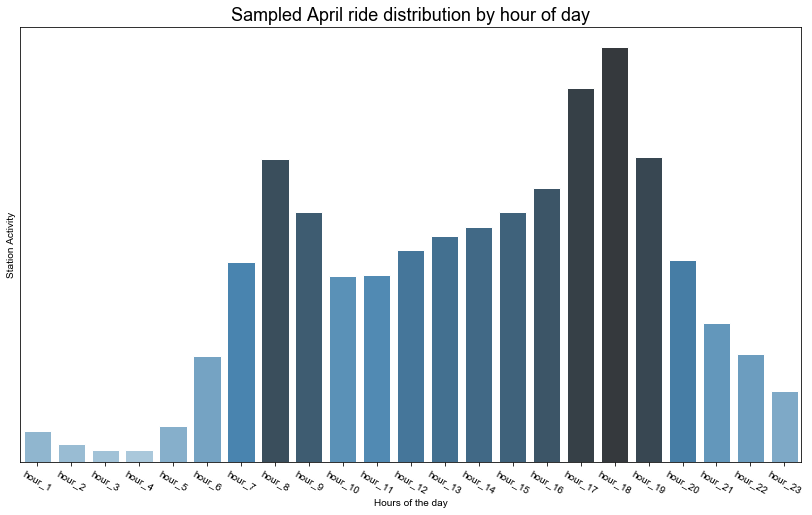

In [37]:
#
#This plots a bar chart by hour of the day and shades by y-axis
dims = (14,8)
fig, ax = plt.subplots(figsize=dims)
sns.set(style='whitegrid', color_codes=True)
pal = sns.color_palette('Blues_d', len(a[66:89].index))
rank = a[66:89].values.argsort().argsort()
sns.barplot(a[66:89].index, a[66:89].values, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=-30)
ax.set_yticks([])
plt.title('Sampled April ride distribution by hour of day', fontsize=18)
plt.xlabel('Hours of the day')
plt.ylabel('Station Activity')
plt.show()

In [38]:
#
#Sorting the data as it relates to neighborhood and reformatting titles
b = pd.DataFrame(a[2:59], columns=['vals'])
b = b.sort_values(['vals'], ascending=False)
b = b.reset_index()
b['index'] = [i.replace('neighborhood_', '') for i in b['index']]

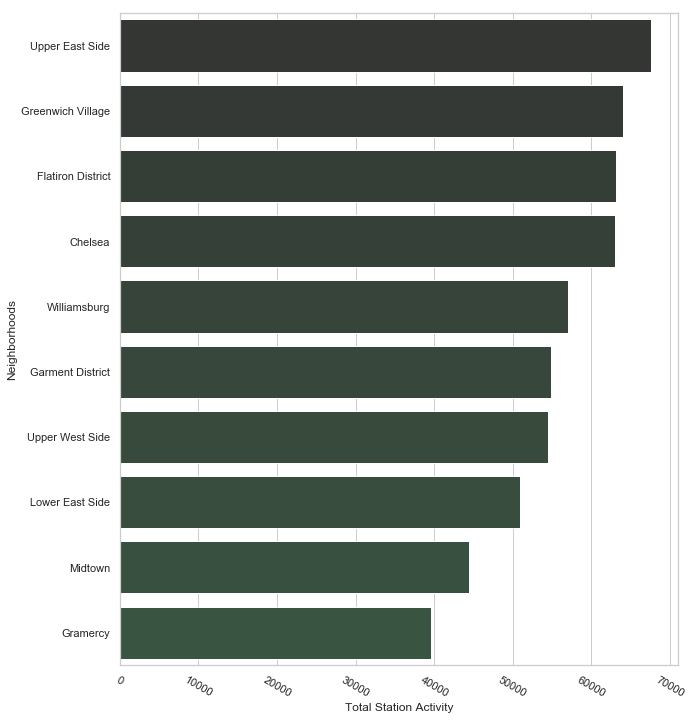

In [39]:
#
#Plotting the neighborhoods with the top activity
dims = (10,12)
fig, ax = plt.subplots(figsize=dims)
sns.set(style='whitegrid', color_codes=True)
pal = sns.color_palette('Greens_d', len(b))
rank = b.vals.argsort().argsort()
sns.barplot(b.vals[:10], b['index'][:10], palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=-30)
plt.xlabel('Total Station Activity')
plt.ylabel('Neighborhoods')
plt.show()